In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import seaborn as sns
import pandas as pd
from keras.datasets import mnist
from icecream import ic
from keras.utils import to_categorical
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm


In [ ]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.normal(0, 1, (output_size, input_size))
        self.bias = np.random.normal(0, 1, (output_size, 1))

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output

    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.matmul(
            (np.identity(n) - self.output.T) * self.output, output_gradient
        )

class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            return sigmoid(x) * (1 - sigmoid(x))

        super().__init__(sigmoid, sigmoid_prime)

class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0, x)

        def relu_prime(x):
            return np.where(x > 0, 1, 0)

        super().__init__(relu, relu_prime)


class NeuralNetwork:
    def __init__(self, model, loss, loss_prime):
        self.model = model
        self.loss = loss
        self.loss_prime = loss_prime

        self.history_loss = []
        self.history_accuracy = []

    def predict(self, input):
        output = input
        for layer in self.model:
            output = layer.forward(output)
        return output

    def train(
        self,
        x_train,
        y_train,
        epochs=1000,
        learning_rate=10e-5,
        batch_size=32,
    ):

        for e in tqdm(range(epochs), desc="Epoch"):
            error = 0
            correct = 0

            indices = np.arange(x_train.shape[0])
            np.random.shuffle(indices)
            x_train = x_train[indices]
            y_train = y_train[indices]

            for x, y in zip(x_train, y_train):
                # forward
                output = self.predict(x)

                if (np.argmax(output) == np.argmax(y)):
                    correct += 1

                # error
                error += self.loss(y, output)

                # backward
                grad = self.loss_prime(y, output)
                for layer in reversed(self.model):
                    grad = layer.backward(grad, learning_rate)

            self.history_loss.append(error / len(x_train))
            self.history_accuracy.append(correct / len(y_train))

    def show_train_history(self, size = (8,6)):
        fig, ax = plt.subplots(1, 2, figsize = size)
        ax[0].plot(self.history_loss)
        ax[0].set_title('Loss')
        ax[1].plot(self.history_accuracy)
        ax[1].set_title('Accuracy')

In [ ]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def cross_entropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    log_likelihood = -np.log(y_pred)
    loss = np.sum(y_true * log_likelihood) / n_samples
    return loss


def derivative_cross_entropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    d_loss = (y_pred - y_true) / n_samples
    return d_loss

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        17

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



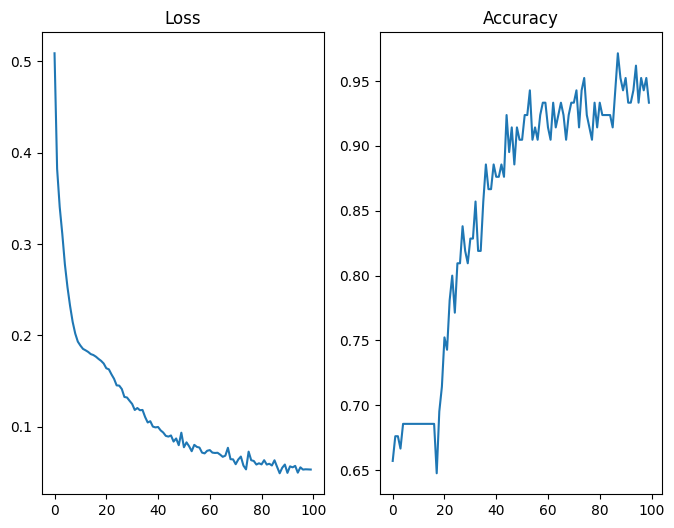

In [ ]:
# @title Iris Test
iris = datasets.load_iris()
data_x = iris.data.reshape(iris.data.shape[0], 4, 1)
cat = to_categorical(iris.target)
data_y = cat.reshape(cat.shape[0], 3, 1)

X_train, X_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.3, random_state=777
)

np.random.seed(23)
perseptron = NeuralNetwork(
    [Dense(4, 10), Tanh(), Dense(10, 10), Tanh(), Dense(10, 3), Softmax()],
    cross_entropy,
    derivative_cross_entropy
)

perseptron.train(X_train, y_train, learning_rate=10e-3, epochs=100, batch_size=100)
perseptron.show_train_history()

predictions = [
    np.argmax(perseptron.predict(x)) for x in X_test]
print(classification_report([np.argmax(y) for y in y_test], predictions))



array([5, 0, 4], dtype=uint8)

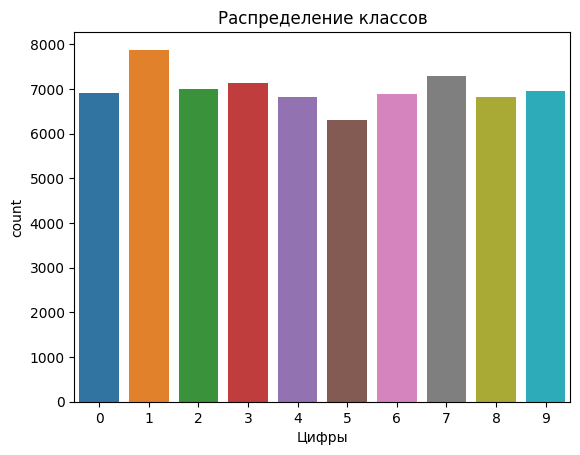

In [ ]:
import warnings

(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

# Suppress all warnings
warnings.filterwarnings("ignore")

sns.countplot(x = y)
plt.title('Распределение классов')
plt.xlabel('Цифры')
plt.show()

# Reset the warning filter to its default state
warnings.filterwarnings("default")


Values per class:  [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.48      0.85      0.61       980
           1       0.74      0.86      0.80      1135
           2       0.39      0.60      0.47      1032
           3       0.47      0.73      0.57      1010
           4       0.63      0.80      0.70       982
           5       0.74      0.05      0.09       892
           6       0.17      0.00      0.00       958
           7       0.61      0.84      0.71      1028
           8       0.35      0.34      0.35       974
           9       0.48      0.04      0.08      1009

    accuracy                           0.52     10000
   macro avg       0.50      0.51      0.44     10000
weighted avg       0.51      0.52      0.45     10000



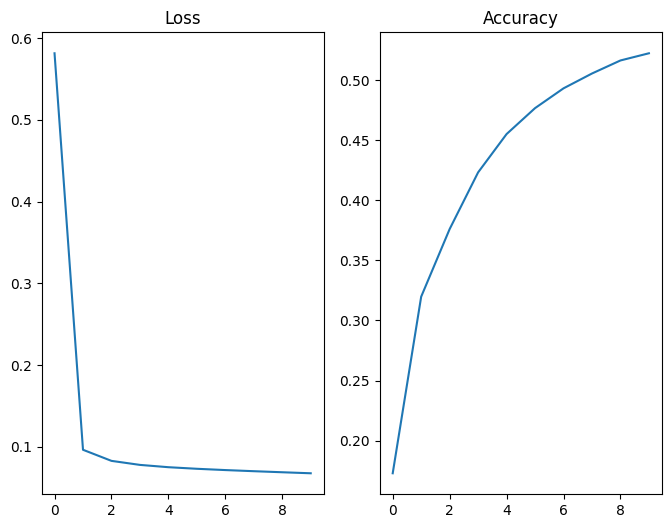

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Prereprocessing
x_train = x_train.reshape(x_train.shape[0], 28 * 28, 1)
x_train = x_train.astype("float32") / 255
x_test = x_test.reshape(x_test.shape[0], 28 * 28, 1)
x_test = x_test.astype("float32") / 255
y_train = to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0], 10, 1)
y_test = to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0], 10, 1)

# values per class
print('Values per class: ', np.bincount(np.argmax(y_train, axis=1).flatten()))

np.random.seed(23)
mnistm = NeuralNetwork(
    [Dense(28 * 28, 30), Tanh(), Dense(30, 10), Tanh()],
    mse,
    mse_prime
)

mnistm.train(x_train, y_train, learning_rate=10e-3, epochs=10)
mnistm.show_train_history()

predictions = [
    np.argmax(mnistm.predict(x)) for x in x_test]
print(classification_report([np.argmax(y) for y in y_test], predictions))

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
x_t = x_train.reshape(len(x_train), 1, 28, 28)
y_t = y_train.reshape(len(y_train), 10 ,1)

NameError: ignored

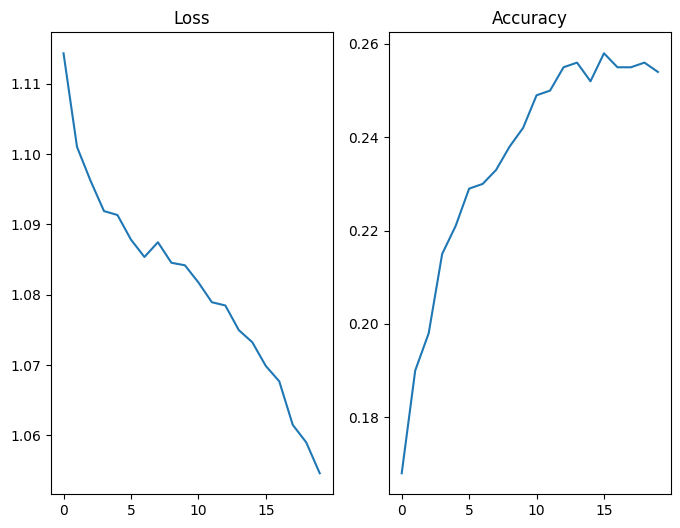

In [ ]:
CNN_Network = NeuralNetwork([
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 10),
    Softmax()], cross_entropy, derivative_cross_entropy)


CNN_Network.train(x_t[:1000], y_t[:1000], learning_rate=10e-3, epochs=20)
CNN_Network.show_train_history()